# Experiments as Iterators:  asyncio in Science

<ul>
<li>Daniel Allan</li>
<li>Thomas Caswell</li>
<li>Kenneth Lauer</li>
</ul>

<p>Brookhaven National Lab</p>
<p>Source: https://github.com/NSLS-II</p>
<p>Project Documentation: https://NSLS-II.github.io</p>
</center>

## Origin of this Project

National Synchrontron Light Source II at Brookhaven National Lab

![NSLS-II](https://www.bnl.gov/ps/images/NSLS2-arial-1080px.jpg)

## NSLS-II

* 12 semi-independent research groups, scaling up to 60 in ~5 years
* Scaling up to 19 Pb/year in "expensive pixels"
* No sacred data formats...
* ... but one validatable, extensible (NoSQL) schema for all:
  * metadata
  * data or *references* to data

## Data Acquisition Software Design Goals

* Integrate with the **scipy stack**.
* Support **streaming** data analysis.
* Capture metadata to record
  * a detailed **snapshot** of the hardware (all experiment state);
  * and the scientist's **intention**, the meaning of the measurements.
* Make datasets **searchable** with rich queries on metadata and data.
* As much as possible, minimize inventing a domain-specific language.

Traditional data acquisition script:

```python
for i in range(5):
    try:
        put('MOTOR_ID', i)
        value = get('DETECTOR_ID')
        # bespoke I/O code
    except:
        # bespoke cleanup to ensure hardware safety
```

Metadata is stuffed into filenames or custom headers.

### ophyd (device abstraction layer)

```python
In [3]: import ophyd

In [4]: motor = ophyd.EpicsMotor('MOTOR_ID', name='motor')

In [5]: motor.read()
Out[5]: {'motor':
            {'value': 5.0,
             'timestamp': 1468325228.751564}}
         
In [6]: motor.set(6.0)
```

Devices are expected to support a common interface: `read`, `set`, `stop`, ....

Our devices talk to EPICS, but yours could talk to LabView, RasberryPi, raw serial, etc.

Devices provide human-friendly names (useful during analysis) and a hierarchical structure.

```python
class MultiAxisMirror(ophyd.Device):
    x = ophyd.Component(ophyd.EpicsMotor, ':X')
    y = ophyd.Component(ophyd.EpicsMotor, ':Y')
    pitch = ophyd.Component(ophyd.EpicsMotor, ':P')


mirror = MultiAxisMirror('SOME_ID', name='mirror')

In [1]: mirror.read()
Out[1]: {'mirror_x': {'value': 1.0, ...},
   ...:  'mirror_y': {'value': 1.5, ...},
   ...:  'mirror_pitch': {'value': 0.3, ...}}
```


### bluesky (experiment specification/execution)

New-style data acquisition program:

```python
from bluesky.plans import (open_run, close_run,
                           abs_set,
                           trigger_and_read)
                           
def plan():
    "scan 'motor' from 1 to 5 while reading 'det'"
    yield from open_run(some_metadata_dict)
    for i in range(5):
        yield from abs_set(motor, i)
        yield from trigger_and_read([det])
    yield from close_run()

RE(plan())  # execute (I/O and cleanup for free!)
```

### A Two-Slide Crash Course in ``yield`` and ``yield from``

In [89]:
# Python 2.5+ (PEP 342)

def g():
    # g is a 'generator'
    yield 1
    yield 2
    
a = g()  # a is a 'generator instance'

In [90]:
next(a)

1

In [91]:
next(a)

2

In [92]:
list(g())

[1, 2]

In [93]:
# Python 3.3+ (PEP 380)

def h():
    yield 0
    yield from g()
    yield 4

list(h())

[0, 1, 2, 4]

Go watch James Powell's *Generators Will Free Your Mind* on YouTube!

## The rest of this talk:

(1) How the **RunEngine** `RE` executes the instructions in the `plan`

(2) Neat implications of expressing a **science experiment as a generator**

(3) Reliably **capturing state and semantics** is a critical input to reproducible workflows in experimental science

## The RunEngine from Scratch

In Which We Built Progressively More Complex Implementations

### A 'plan' is an iterable of 'messages'

A `Msg` is a `namedtuple` with four fields:

* a **command**, given as a string, e.g., ``'set'`` or ``'sleep'``
* a target **obj**, e.g., ``motor`` (if applicable)
* positional **args**
* **kwargs**

In [94]:
from bluesky import Msg

Msg('sleep', None, 1)

sleep: (None), (1,), {}

### Version 0: the simplest possible RunEngine

In [98]:
import time
from bluesky import Msg

function_map = {'sleep': lambda msg: time.sleep(*msg.args),
                'print': lambda msg: print(*msg.args)}

def RE_v0(plan):
    for msg in plan:
        print('PROCESSING: %r' % (msg,))
        func = function_map[msg.command]
        func(msg)
        
sleepy_plan = [Msg('sleep', None, 1),
               Msg('print', None, 'HELLO WORLD')]

RE_v0(sleepy_plan)

PROCESSING: sleep: (None), (1,), {}
PROCESSING: print: (None), ('HELLO WORLD',), {}
HELLO WORLD


### Version 1: a RunEngine that supports adaptive plan logic

In [99]:
from bluesky.utils import ensure_generator

def RE_v1(plan):
    plan = ensure_generator(plan)
    last_result = None

    while True:
        try:
            msg = plan.send(last_result)
        except StopIteration:
            break
        print('PROCESSING: %r' % (msg,))
        func = function_map[msg.command]
        last_result = func(msg)

function_map['sum'] = lambda msg: sum(msg.args)

In [100]:
def adding_plan():
    "Ask the RunEngine to add to numbers. Print the result."
    yield Msg('sleep', None, 1)
    result = yield Msg('sum', None, 3, 4)
    print('RECEIVED:', result)
    
RE_v1(adding_plan())

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (3, 4), {}
RECEIVED: 7


In [102]:
def adaptive_adding_plan():
    "Keep adding 3 until the result is greater than 8."
    result = 1
    while True:
        yield Msg('sleep', None, 1)
        result = yield Msg('sum', None, result, 3)
        print('RECEIVED:', result)
        if result > 8:
            print('we are done')
            break
            
RE_v1(adaptive_adding_plan())

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (1, 3), {}
RECEIVED: 4
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (4, 3), {}
RECEIVED: 7
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (7, 3), {}
RECEIVED: 10
we are done


### Version 2: refactor as a callable class

A class, unlike a simple function, gives us access to the internal state.

In [ ]:
class RunEngine_v2:
    def __call__(self, plan):
        self._run(plan)
    
    def _run(self, plan):
        plan = ensure_generator(plan)
        last_result = None

        while True:
            try:
                msg = plan.send(last_result)
            except StopIteration:
                break
            print('PROCESSING: %r' % (msg,))
            func = function_map[msg.command]
            last_result = func(msg)

In [103]:
# It still works.
RE_v2 = RunEngine_v2()
RE_v2(adaptive_adding_plan())

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (1, 3), {}
RECEIVED: 4
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (4, 3), {}
RECEIVED: 7
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (7, 3), {}
RECEIVED: 10
we are done


### Version 3: toward a RunEngine that supports interruptions / resuming

* The RunEngine still manages the main loop, processing the plan
* asyncio provides an outer event loop that manages multiple frames of execution

In [105]:
import asyncio

loop = asyncio.get_event_loop()

# Reimplement all command functions as coroutines.

@asyncio.coroutine
def _sum(msg):
    return sum(msg.args)

@asyncio.coroutine
def _sleep(msg):
    yield from asyncio.sleep(*msg.args, loop=loop)

In [106]:
class RunEngine_v3:
    def __init__(self):
        loop = asyncio.new_event_loop()
        self.coroutine_map = {'sleep': _sleep,
                             'sum': _sum}
        
    def __call__(self, plan):
        self._task = loop.create_task(self._run(plan))
        loop.run_until_complete(self._task)
        
        if self._task.done() and not self._task.cancelled():
            exc = self._task.exception()
            if exc is not None:
                raise exc
                
    @asyncio.coroutine
    def _run(self, plan):
        plan = ensure_generator(plan)
        last_result = None

        while True:
            try:
                msg = plan.send(last_result)
            except StopIteration:
                break
            print('PROCESSING: %r' % (msg,))
            coroutine = self.coroutine_map[msg.command]
            last_result = yield from coroutine(msg)

In [107]:
# And it still works
RE_v3 = RunEngine_v3()
RE_v3(adaptive_adding_plan())

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (1, 3), {}
RECEIVED: 4
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (4, 3), {}
RECEIVED: 7
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (7, 3), {}
RECEIVED: 10
we are done


## Execution can be interrupted and cleanly resumed

In [108]:
from bluesky import RunEngine  # finally, the real thing

# Make a RunEngine.
RE = RunEngine({})

# Teach it our toy command, 'sum'.
@asyncio.coroutine
def _sum(msg):
    return sum(msg.args)

RE.register_command('sum', _sum)
 
# Make it verbose, as our demo implementations were.
RE.msg_hook = lambda msg: print("PROCESSING:", msg)

In [110]:
RE(adaptive_adding_plan())

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (1, 3), {}
RECEIVED: 4
PROCESSING: sleep: (None), (1,), {}
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Deferred pause acknowledged. Continuing to checkpoint.

Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:

resume()  --> will resume the scan
 abort()  --> will kill the scan with an 'aborted' state to indicate
              the scan was interrupted
  stop()  --> will kill the scan with a 'finished' state to indicate
              the scan stopped normally

Pro Tip: Next time, if you want to abort, tap Ctrl+C three times quickly.

Pausing...


[]

In [111]:
RE.resume()

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (1, 3), {}
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (4, 3), {}
RECEIVED: 7
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (7, 3), {}
RECEIVED: 10
we are done


[]

In [112]:
def adaptive_adding_plan_with_checkpoints():
    "Keep adding 3 until the result is greater than 8."
    ret = 1
    while True:
        yield Msg('checkpoint')  # NEW
        yield Msg('sleep', None, 1)
        ret = yield Msg('sum', None, ret, 3)
        print('RECEIVED:', ret)
        if ret > 8:
            print('we are done')
            break

In [113]:
RE(adaptive_adding_plan_with_checkpoints())

PROCESSING: checkpoint: (None), (), {}
PROCESSING: sleep: (None), (1,), {}
A 'deferred pause' has been requested. The RunEngine will pause at the next checkpoint. To pause immediately, hit Ctrl+C again in the next 10 seconds.
Deferred pause acknowledged. Continuing to checkpoint.
PROCESSING: sum: (None), (1, 3), {}
RECEIVED: 4
PROCESSING: checkpoint: (None), (), {}
Pausing...


[]

In [114]:
RE.resume()

PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (4, 3), {}
RECEIVED: 7
PROCESSING: checkpoint: (None), (), {}
PROCESSING: sleep: (None), (1,), {}
PROCESSING: sum: (None), (7, 3), {}
RECEIVED: 10
we are done


[]

## Plans can handle exceptions

In [115]:
def problematic_plan():
    yield Msg('sleep', None, 1)
    print("ERROR!")
    raise Exception("Problematic!")
    
RE(problematic_plan())

PROCESSING: sleep: (None), (1,), {}
ERROR!


Exception: Problematic!

In [116]:
from bluesky.plans import finalize_wrapper

def cleanup():
    # e.g., move motors back to safe positions.
    yield Msg('sleep', None, 2)
    print("Everything has been made safe.")
    
def make_safe(plan):
    yield from finalize_wrapper(plan, cleanup())

RE(make_safe(problematic_plan()))

PROCESSING: sleep: (None), (1,), {}
ERROR!
PROCESSING: sleep: (None), (2,), {}
Everything has been made safe.


Exception: Problematic!

In [117]:
from bluesky.plans import finalize_wrapper
    
def raises_in_RE():
    "will cause an error inside _sleep() coroutine"
    yield Msg('sleep', None, 'a')
    
RE(raises_in_RE())

PROCESSING: sleep: (None), ('a',), {}


TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [118]:
RE(make_safe(raises_in_RE()))

PROCESSING: sleep: (None), ('a',), {}
PROCESSING: sleep: (None), (2,), {}
Everything has been made safe.


TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [119]:
def reckless_plan():
    try:
        yield from raises_in_RE()
    except Exception as exc:
        print("Ignoring:", exc)
    yield Msg('sleep', None, 1)
        
RE(reckless_plan())

PROCESSING: sleep: (None), ('a',), {}
Ignoring: unsupported operand type(s) for +: 'float' and 'str'
PROCESSING: sleep: (None), (1,), {}


[]

## The RunEngine collates all metadata and data into validated dicts

* Dicts contain metadata and data.
* They are validated against a JSON schema.
* Dicts are dispatched to a list of "subscribers".
    * Subscribers can be blocking or non-blocking.
    * Subscribers can be lossy.

Examples:
* Insert dicts into to NoSQL database.
* Print, plot, or produce log entries.
* Write CSV files or HDF5 files.

In [127]:
RE.msg_hook = None  # turn off verbosity

# Use synthetic hardware objects.
from bluesky.examples import det, motor
motor._fake_sleep = 0.25  # sim moving time

from bluesky.plans import (open_run, close_run,
                           abs_set,
                           trigger_and_read)

def plan():
    "scan 'motor' from 1 to 5 while reading 'detector'"
    yield from open_run({'some_metadata': 'hello world'})
    for i in range(5):
        yield from abs_set(motor, i)
        yield from trigger_and_read([det, motor])
    yield from close_run()

In [128]:
RE(plan())

['8af80382-0e94-4d44-954f-0cb1eea9e27f']

In [129]:
RE(plan(), print)

start {'scan_id': 6, 'plan_name': 'plan', 'uid': 'aab16863-06cb-46bc-86aa-87266b95bdad', 'plan_type': 'generator', 'time': 1468426014.826086, 'some_metadata': 'hello world'}
descriptor {'time': 1468426015.082275, 'data_keys': {'motor': {'dtype': 'number', 'object_name': 'motor', 'precision': 3, 'shape': None, 'source': 'motor'}, 'det': {'dtype': 'number', 'object_name': 'det', 'precision': 3, 'shape': None, 'source': 'det'}}, 'name': 'primary', 'uid': 'e2adb396-43f2-4d47-9047-c615800ada5e', 'run_start': 'aab16863-06cb-46bc-86aa-87266b95bdad', 'configuration': {'motor': {'timestamps': {'some_configuration': 0}, 'data': {'some_configuration': 'there is a sandwich in the vacuum chamber'}, 'data_keys': {}}, 'det': {'timestamps': {'some_configuration': 0}, 'data': {'some_configuration': 'there is a sandwich in the vacuum chamber'}, 'data_keys': {}}}, 'object_keys': {'motor': ['motor'], 'det': ['det']}}
event {'timestamps': {'motor': 1468426015.080182, 'det': 1468426015.080562}, 'uid': 'c88f

['aab16863-06cb-46bc-86aa-87266b95bdad']

In [132]:
from bluesky.callbacks import LiveTable

RE(plan(), LiveTable([motor, det]))

+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 11:07:15.7 |      0.000 |      1.000 |
|         2 | 11:07:16.0 |      1.000 |      0.607 |
|         3 | 11:07:16.2 |      2.000 |      0.135 |
|         4 | 11:07:16.5 |      3.000 |      0.011 |
|         5 | 11:07:16.7 |      4.000 |      0.000 |
+-----------+------------+------------+------------+
generator plan ['ecbbe5'] (scan num: 9)


['ecbbe5f7-2163-4b52-bb99-91a58066fa69']

In [133]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


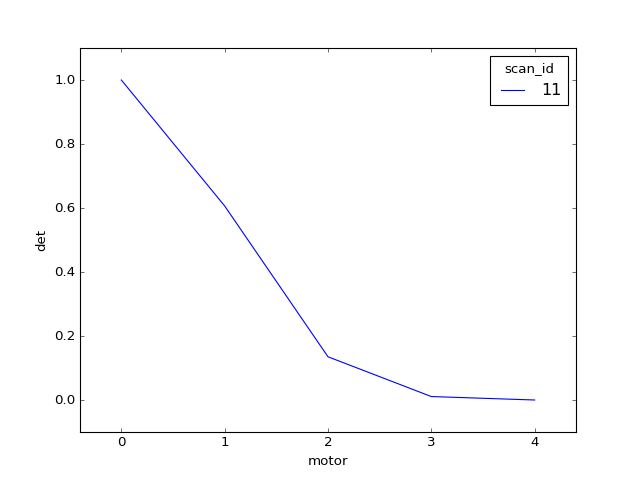

['349d72af-00e6-489f-99c0-798b7b070a9d']

In [135]:
from bluesky.callbacks import LivePlot

RE(plan(), LivePlot('det', 'motor'))

## More Use Cases: Adaptive Steps and Nested Generators

Behold the Power of the Fully *Operational* RunEngine

<IPython.core.display.Javascript object>


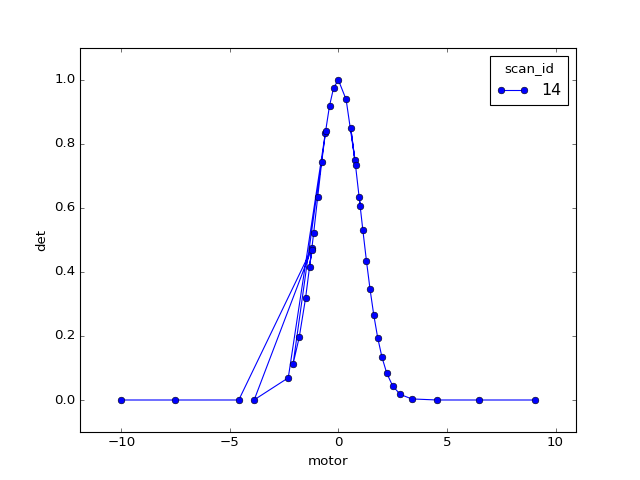

In [141]:
plt.figure();

In [142]:
from bluesky.plans import adaptive_scan
motor._fake_sleep = 0

RE(adaptive_scan([det], 'det', motor, -10, 10, 0.1, 5, 0.1, True),
   LivePlot('det', 'motor', marker='o'))

['171becd4-ebaa-4df6-b573-13c71d19953e']

In [143]:
RE(plan(), LiveTable([motor, det]))

+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 11:10:35.8 |      0.000 |      1.000 |
|         2 | 11:10:35.8 |      1.000 |      0.607 |
|         3 | 11:10:35.8 |      2.000 |      0.135 |
|         4 | 11:10:35.8 |      3.000 |      0.011 |
|         5 | 11:10:35.8 |      4.000 |      0.000 |
+-----------+------------+------------+------------+
generator plan ['6a4eb7'] (scan num: 15)


['6a4eb705-99a3-458d-a03d-b9fbcb127060']

In [144]:
from bluesky.plans import relative_set_wrapper

# We left motor at position 4.0 above.

RE(relative_set_wrapper(plan()), LiveTable([motor, det]))

+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 11:10:56.4 |      4.000 |      0.000 |
|         2 | 11:10:56.4 |      5.000 |      0.000 |
|         3 | 11:10:56.4 |      6.000 |      0.000 |
|         4 | 11:10:56.4 |      7.000 |      0.000 |
|         5 | 11:10:56.4 |      8.000 |      0.000 |
+-----------+------------+------------+------------+
generator relative_set_wrapper ['bdd95f'] (scan num: 16)


['bdd95f3d-7cee-4897-ab5f-aee7cbdd0949']

In [145]:
from bluesky.plans import msg_mutator

def triple_sleep(msg):
    "Alter any sleep messages to triple the sleep time."
    if msg.command == 'sleep':
        t, = msg.args
        new_msg = msg._replace(args=(3 * t,))
        return new_msg
    else:
        return msg

RE.msg_hook = print
RE(msg_mutator(adding_plan(), triple_sleep))

sleep: (None), (3,), {}
sum: (None), (3, 4), {}
RECEIVED: 7


[]

## Additional Info

<p>Source: https://github.com/NSLS-II</p>
<p>Project Documentation: https://NSLS-II.github.io</p>
<p>Document Model: https://NSLS-II.github.io/architecture-overview.html</p>